# Diamonds Predictor Application (Capstone)
This notebook demonstrates the full pipeline:
- EDA & preprocessing
- Classification (clarity)
- Regression (price)
- Clustering (customer segmentation)


Dataset shape: (53940, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


RandomForest accuracy: 0.6948461253244346
Confusion matrix saved at ../outputs/plots/confusion_clarity.png


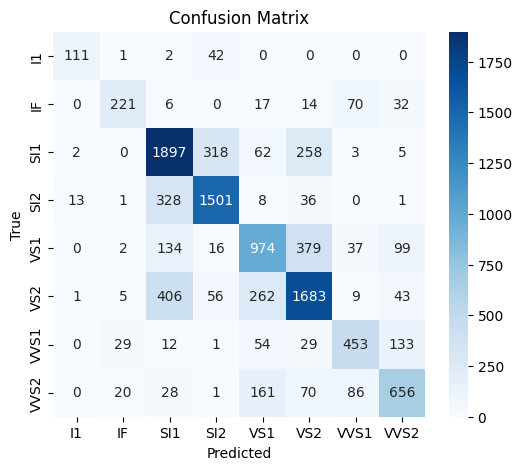

Regression R2 score: 0.9999626163042683
Cluster assignments (first 10): [0 2 0 2 1 1 0 0 2 1]
All plots saved to: ../outputs/plots/


In [12]:
# Diamonds Predictor - Full Workflow in One Cell

import os, sys
sys.path.append("..")  # allow importing diamonds/ package

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from diamonds.Analyzer import Analyzer
from diamonds.Classifier import Classifier
from diamonds.Regressor import Regressor
from diamonds.Clustering import Clustering

# -----------------------
# Paths
DATA_PATH = "../data/diamonds.csv"  # adjust if needed
PLOTS_PATH = "../outputs/plots/"
os.makedirs(PLOTS_PATH, exist_ok=True)

# -----------------------
# Load dataset
an = Analyzer(csv_path=DATA_PATH)
print("Dataset shape:", an.df.shape)
display(an.df.head())

# -----------------------
# Data exploration (manual saving)
# Correlation matrix
plt.figure(figsize=(10,8))
numeric_cols = an.df.select_dtypes(include=np.number).columns
sns.heatmap(an.df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.savefig(os.path.join(PLOTS_PATH, "correlation_matrix.png"))
plt.close()

# Histograms for categorical features
cat_cols = an.df.select_dtypes(include="object").columns
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=an.df)
    plt.title(f"{col} distribution")
    plt.savefig(os.path.join(PLOTS_PATH, f"{col}_hist.png"))
    plt.close()

# -----------------------
# -----------------------
# Classification: Predict 'clarity'
X_class = an.df.drop(columns=["clarity"])
y_class = an.df["clarity"]

# One-hot encode categorical features
X_class_encoded = pd.get_dummies(X_class, drop_first=True)

# Train/test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class_encoded, y_class, test_size=0.2, random_state=42
)

# Scale features
sc = StandardScaler()
X_train_c_s = sc.fit_transform(X_train_c)
X_test_c_s = sc.transform(X_test_c)

# Train classifier
clf = Classifier()
clf.fit(X_train_c_s, y_train_c, model_name="random_forest")
acc = clf.score(X_test_c_s, y_test_c, metric="accuracy")
print("RandomForest accuracy:", acc)
y_pred = clf.predict(X_test_c_s)

# Confusion matrix plotting
def plot_confusionMatrix(y_true, y_pred, out_path=None):
    labels = np.unique(np.concatenate((y_true, y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")
    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path)
        print(f"Confusion matrix saved at {out_path}")
    plt.show()
    return cm

plot_confusionMatrix(y_test_c, y_pred, out_path=os.path.join(PLOTS_PATH, "confusion_clarity.png"))

# -----------------------
# Regression: Predict 'price'
y_price = an.df["price"]
X_price = an.df.drop(columns=["price"])

# Encode categorical features
X_price_encoded = pd.get_dummies(X_price, drop_first=True)

# Train/test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_price_encoded, y_price, test_size=0.2, random_state=42
)

# Scale features
X_train_r_s = sc.fit_transform(X_train_r)
X_test_r_s = sc.transform(X_test_r)

# Train regressor
reg = Regressor()
reg.fit(X_train_r_s, y_train_r, model_name="random_forest")
y_pred_reg = reg.predict(X_test_r_s)
r2 = reg.score(X_test_r_s, y_test_r, metric="r2")
print("Regression R2 score:", r2)

# -----------------------
# Clustering (customer segmentation)
clust = Clustering()
clust.fit(X_train_c_s, method="kmeans", n_clusters=3)
clusters = clust.predict(X_test_c_s)
print("Cluster assignments (first 10):", clusters[:10])

# -----------------------
print("All plots saved to:", PLOTS_PATH)
